# Week 1 Notes

This week, the focus was on refreshing baseline knowledge on Tensorflow, neural networks, and more simple methods/principles being used to classify nodes in graphs. Some other problems present in graph machine learning are also reviewed.

## Topics Covered:

1. Review of Tensorflow 2.0 with eye towards using it for optimization.
2. Quick overview of simpler methods for graph machine learning.
3. Review how graph data is structured for these applications.
4. Review neural networks.


## Review of Tensorflow 2.0

# Simple Optimization

To "warm-up", I'll use the tensorflow framework to solve a simple optimization problem. This will be done with the analytic gradient, and the autodifferentiation procedure which is standard in Tensorflow.

First, define the function we will be using which is the Beale function:

$$ f(x,y) = (1.5-x+xy)^2 + (2.25-x+xy^2)^2 + (2.625-x+xy^3)^2$$ 

The gradient is:

$$  \nabla f(x,y) =  \begin{bmatrix}
2 x (y^6 + y^4 - 2 y^3 - y^2 - 2 y + 3) + 5.25 y^3 + 4.5 y^2 + 3 y - 12.75 \\
 6 x (x (y^5 + 0.666667 y^3 - y^2 - 0.333333 y - 0.333333) + 2.625 y^2 + 1.5 y + 0.5)
\end{bmatrix}  $$

In [57]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

def f_beale(x):
    return (tf.convert_to_tensor( (1.5-x[0]+x[0]*x[1])**2 + (2.25-x[0]+x[0]*x[1]**2)**2 + (2.625-x[0]+x[0]*x[1]**3)**2) )

def grad_beal(x):
    dx = 2*x[0]*(x[1]**6 + x[1]**4 - 2*x[1]**3 - x[1]**2-2*x[1] + 3) + 5.25*x[1]**3+4.5*x[1]**2+3*x[1]-12.75
    dy = 6*x[0]*(x[0]*(x[1]**5 + 2.0/3.0 * x[1]**3-x[1]**2-1.0/3.0 * x[1]-1.0/3.0) + 2.625*x[1]**2+1.5*x[1]+.5)
    return(tf.convert_to_tensor([dx,dy]))

def AD_beale(x):
    x = tf.Variable(x,dtype = tf.float32) 
    with tf.GradientTape(persistent = True) as dv:
        temp_beale = f_beale(x)
    dx = dv.gradient(temp_beale, x)
    return(dx)

We can see below that the results end up being the same for the derivatives:

In [58]:
grad_beal([1,1]) == AD_beale([1,1])

<tf.Tensor: shape=(2,), dtype=bool, numpy=array([ True,  True])>

From here, we will attempt to solve the problem using stochastic gradient descent:

In [59]:
opt = tf.keras.optimizers.SGD(learning_rate = .01)
#opt = tf.keras.optimizers.Adam(learning_rate = .01)
x_0 = tf.Variable([1.0,1.0],dtype = tf.float32)
func_for_opt = lambda: f_beale(x_0)

for epoch in range(1500):
    opt.minimize(func_for_opt, [x_0]).numpy()

x_0

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([2.9961617 , 0.49904037], dtype=float32)>

In [60]:
x_vals = tf.Variable([1.0,2.0,3.0],name = "x_vals")
x_vals_two = tf.Variable([2.0,3.0,4.0],name = "x_vals_two")
with tf.GradientTape() as tape:
    y = x_vals[0]**3+x_vals[2]*x_vals[1]**2 + 2*x_vals[2]+100
    z_one = x_vals[1]*(4*(y) + x_vals[0]**2)    
    y_two = x_vals_two[0]**3+x_vals_two[2]*x_vals_two[1]**2 + 2*x_vals_two[2]+100
    z_two = x_vals_two[1]*(4*(y_two) + x_vals_two[0]**2)
    z = z_one + z_two
    
a, b = tape.gradient(z , [z,x_vals_two]) 
print(b)    

tf.Tensor([156. 900. 132.], shape=(3,), dtype=float32)


In [61]:
def f_rosenbrock(vals):
    return(tf.convert_to_tensor(  (1-vals[0])**2 + 100*(vals[1]-vals[0]**2)  ) )

def const1_rosenbrock(vals):    
    return(tf.convert_to_tensor( 1.0*((vals[0]-vals[1])**3 - vals[1] + 1)   ))

def const2_rosenbrock(vals):    
    return(tf.convert_to_tensor( 1.0*(vals[0]+vals[1]-2)   ))

def rosenbrock_lagrange(vals):
    return(  f_rosenbrock(vals)+const1_rosenbrock(vals)+const2_rosenbrock(vals)   )

f_rosenbrock([2.0,1.0])

<tf.Tensor: shape=(), dtype=float32, numpy=-299.0>

In [62]:
opt = tf.keras.optimizers.SGD(learning_rate = 1e-7,momentum = .9)
#opt = tf.keras.optimizers.Adam(learning_rate = 5e-6)
x_0 = tf.Variable([.1,.1 ],dtype = tf.float32)
func_for_opt = lambda: tf.abs(f_rosenbrock(x_0))


#for epoch in range(1000):
i=1
while (func_for_opt().numpy()>1e-4)&(i < 60000):
#    print(i)
    if i%1000 == 0:
        print("At iteration " + str(i) +  " current results are " + str(x_0.numpy() )+ " with function value of "+str( func_for_opt().numpy())  + ".")
    opt.minimize(func_for_opt, [x_0]).numpy()
    i+=1


    opt = tf.keras.optimizers.SGD(learning_rate = 1e-8,momentum = .9)
#opt = tf.keras.optimizers.Adam(learning_rate = 1e-6)
x_0 = tf.Variable([1.1,1.1  ],dtype = tf.float32)
func_for_opt = lambda: tf.abs(rosenbrock_lagrange(x_0))


#for epoch in range(1000):
i=1
while (func_for_opt().numpy()>1e-6)&(i < 100000):
#    print(i)
    if i%5000 == 0:
        print("At iteration " + str(i) +  " current results are " + str(x_0.numpy() )+ " with function value of "+str( func_for_opt().numpy())  + ".")
    opt.minimize(func_for_opt, [x_0]).numpy()
    i+=1

print("Final results at iteration " + str(i) +  " where the final results are " + str(x_0.numpy() )+ " with function value of "+str( func_for_opt().numpy())  + ".") 

At iteration 1000 current results are [0.10021782 0.09899362] with function value of 9.704609.
At iteration 2000 current results are [0.10043389 0.09799524] with function value of 9.600047.
At iteration 3000 current results are [0.10064995 0.09699687] with function value of 9.495476.
At iteration 4000 current results are [0.10086602 0.09599849] with function value of 9.390896.
At iteration 5000 current results are [0.10108819 0.09500011] with function value of 9.286171.
At iteration 6000 current results are [0.10131171 0.09400173] with function value of 9.181408.
At iteration 7000 current results are [0.10153522 0.09300335] with function value of 9.076633.
At iteration 8000 current results are [0.10175874 0.09200498] with function value of 8.971851.
At iteration 9000 current results are [0.10198226 0.0910066 ] with function value of 8.867058.
At iteration 10000 current results are [0.10220578 0.09000822] with function value of 8.762255.
At iteration 11000 current results are [0.1024292

The results above show the basic steps of working through a mathematical optimization problem. At this point, we pivot to the use of the mathematical optimization framework to solve a statistical problem. 

Simple linear regression uses the mean squared error function to find a linear relationship between a set of features and an outcome. This is defined as:

$$ MSE(\beta) = \frac{\sum_{i=1}^N (y_i - \bar{\beta}X_i )^2 }{N}$$

Here, we step through a simple example of linear regression using tensorflow and an implementation of the MSE function.

The functions are defined in the code below:

In [63]:
def MSE(y_val ,x_val,weights):
    output = tf.tensordot(X, weights, axes=1 ) 
    mse_val =  tf.reduce_mean( tf.square( output - y_val ) )
    return(mse_val)

For this numerical example, we'll use the cars data-set and fit a few different variables to predict the gas mileage. 

First step: Load the data into the environment and form the design matrix:

In [64]:
data = pd.read_csv( '../cars.csv' )
continuous_features = data[ [ "Identification.Year","Engine Information.Engine Statistics.Horsepower","Engine Information.Engine Statistics.Torque"] ].values / 100 
X = np.concatenate( [ continuous_features ] , axis=1 )
X = np.append(np.ones((X.shape[0],1) ) , X, axis=1)
Y = data[ [ 'Fuel Information.City mpg' ] ].values

# Perform basic subset selection in the code:
train_features , test_features ,train_labels, test_labels = train_test_split( X , Y , test_size=0.2 )
# Training data.
X = tf.Variable( train_features , dtype=tf.float32 )
Y = tf.Variable( train_labels , dtype=tf.float32 )                                                         
# Testing data
test_X = tf.Variable( test_features , dtype=tf.float32 ) 
test_Y = tf.Variable( test_labels , dtype=tf.float32 ) 
num_features = X.shape[1]
# Define the coefficientst that we'll be starting with:
#weights = tf.Variable(tf.random.normal((num_features,1)))
weights = tf.Variable(tf.ones(4))

def MSE(y_val ,x_val,weights):
    output = tf.tensordot(X, weights, axes=1 )
    mse_val =  tf.reduce_mean( tf.square( output - y_val ) )
    return(mse_val)

#mse_opt = tf.keras.optimizers.SGD(.001)
mse_opt = tf.keras.optimizers.Adam(.001)
weight_vals = weights
def temp_mse(weight_vals):
    return(MSE(Y,X,weight_vals))
func_for_opt = lambda: tf.abs(temp_mse(weight_vals))
mse_opt.minimize(func_for_opt, [weight_vals]).numpy()

i=1
while (temp_mse(weight_vals).numpy()>1e-2)&(i < 1000):
#    print(i)
    if i%100 == 0:
        print("At iteration " + str(i) +  " function value is "+str( func_for_opt().numpy())  + ".")
    mse_opt.minimize(func_for_opt, [weight_vals]).numpy()    
    i+=1

At iteration 100 function value is 68.73872.
At iteration 200 function value is 44.320713.
At iteration 300 function value is 31.346407.
At iteration 400 function value is 25.294987.
At iteration 500 function value is 22.850306.
At iteration 600 function value is 21.992468.
At iteration 700 function value is 21.717325.
At iteration 800 function value is 21.619259.
At iteration 900 function value is 21.564722.


In [65]:
import os

In [66]:
os.getcwd()

'/home/peter/Dropbox/Projects/Work on Graphs/Notes'

## What Makes Graph Machine Learning Unique?

Machine learning on networks is unique from other machine learning domains in that 






## Survey of Methods Used for Graph Machine Learning

The techniques used in graph machine learning come in three main varieties:

1. "Traditional" machine learning methods which attempt to deploy standard techniques like logistic regression. 
2. Embedding methods which define some transformation to represent each node as a vector of features.
3. Neural network methods. The most standard method in this area is the graph convolutional neural network (GCN).


### Traditional Methods

This represents any "traditional" approach to machine learning that might also be applied to graph theory without taking steps to cope with the issue of the data being noneuclidean. This may be fairly simplistic - for example, we may form an adjacency matrix using node lists in the graph and fit a logistic regression model to classify each node:

In [67]:
# Example on Karate data-set

The primary problem with traditional methods is the ignorance of the structure of the data. The formation of the adjacency matrix is a necessary step, but not further work is done to try to represent the neighborhood (to be defined below) of each node, or how other factors may interact. 

Furthermore, if you are using an adjacency matrix, you are necessary working with a data-set where each column is somewhat dependent on the others which will introduce numerical instability to the model.

### Embedding Methods

We can define the neighborhood for a node as:




Embedding methods encode the neighborhood of each node as a feature vector that expresses the "location" of each node. The node embedding will produce a large number with its neighbors, and a small number with non-neighbors. These features can then be used as a series of factors for other algorithms. In this manner, we've managed to represent each node as a set of features which are more amenable to machine learning methods (why?).

To perform a simple testing exercise to try to predict the category of records contained in a data-set.This exercise will focus on simpler classification methods to predict results. This includes a graph embedding method (node2vec). See the original paper [here](https://arxiv.org/abs/1607.00653). I will go more deeply into the theory of the methods next week, but the information below provides a simple example of the implementation used in [Stellargraph](https://stellargraph.readthedocs.io/en/stable/).


#### Data Description:

**From the README:**

The Cora dataset consists of Machine Learning papers. These papers are classified into one of the following seven classes:

		Case_Based
		Genetic_Algorithms
		Neural_Networks
		Probabilistic_Methods
		Reinforcement_Learning
		Rule_Learning
		Theory

The papers were selected in a way such that in the final corpus every paper cites or is cited by atleast one other paper. There are 2708 papers in the whole corpus. 

After stemming and removing stopwords we were left with a vocabulary of size 1433 unique words. All words with document frequency less than 10 were removed.

In [68]:
# install StellarGraph if running on Google Colab
import sys
import stellargraph as sg
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec

%matplotlib inline

In [69]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


Node2vec is founded on using a random walk to sample the node choices over each of the nodes in the graph. Let $c_i$ be the $i$th node in the random walk where $c_i = u$ is the initial node. Then the random walk will be defined as:

$$ P(c_i = x|c_{i-1}=v) = \frac{\pi_{vx}}{Z} \text{ if }(v,x)\in E$$

Where:

* $\pi_{vx}$ is the unnormalized transition probability between node $x$ and $v$.
* $Z$ is the normalizing constant.


The code below implements the 2nd degree random walk on the graph. In this case, we are setting the maximum length of the random walk to 100, and are doing 10 walks per node. 

This is implemented and run through the BiasedRandomWalk algorithm below which will output a list of lists. Each list contains 100 components from the random walk. 

In [70]:
len(walks)

27080

In [71]:
rw = BiasedRandomWalk(G)
walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 27080


As mentioned earlier, the random walk algorithm produces a list of 100 node ids representing the "neighborhood". The first twenty ids from the first node are displayed below:

In [72]:
walks[1][0:20]

[31336,
 31349,
 10531,
 31349,
 31353,
 10531,
 1107567,
 10531,
 194617,
 10531,
 686532,
 31336,
 31349,
 31336,
 1129442,
 43698,
 1129442,
 31336,
 10531,
 1129442]

At this point, we generate the node embeddings for each neighborhood using the Word2vec algorithm. The list comprehension below is just there to format the ids into text strings. After that, the word2vec model is fit on the node lists to generate a list of node embeddings.

In [73]:
str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (model.wv.vectors)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

The graph of the embeddings is provided below;

In [74]:
len(str_walks[0])

100

In [75]:
len(node_embeddings[0])

128

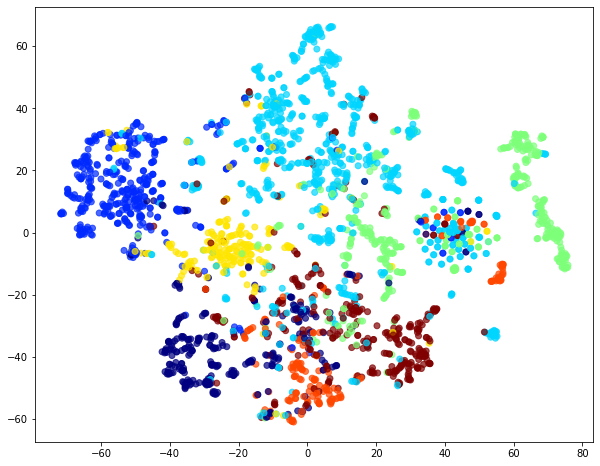

In [76]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

At this point, we have a vector of 100 features which represent the neighborhood of the model. This can be used with 

In [77]:
# X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(node_targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300)
clf.fit(X_train, y_train)

Array shapes:
 X_train = (270, 128)
 y_train = (270,)
 X_test = (2438, 128)
 y_test = (2438,)


LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [78]:
y_pred = clf.predict(X_test)

In [79]:
accuracy_score(y_test, y_pred)

0.7399507793273175

### Neural Network Methods

The final group of methods that are used are neural network models which are discussed at length by Kipf. He seems to have been able to get superior accuracy on several data-sets using this graph based method.

In this method, an adjancency matrix, $A$ is used in neural network layers of:
$$ H^{l+1} = f(H^l,A) = \sigma(AH^lW^l) $$
Where:

* $\sigma$ is a non-linear activation function such as ReLU.
* $H$ is an $N \times F$ matrix; ($N$ is the number of nodes, and $F$ is the number of output features per node).
* $L$ is the number of layers.

A more complete description of the method is located [here](https://tkipf.github.io/graph-convolutional-networks/]).
